여러 HAR 공개 데이터 셋 학습 및 테스트 코드

transformer 모델

## 작업환경 확인

In [1]:
# 학습 할때 몇 번째 gpu를 사용할것인지 설정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [2]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')
curdir = os.getcwd()
print(curdir)

/tf/repos_old/09_Variational/Code_old


In [3]:
# 서버 이름
import socket
hostname = socket.gethostname()
print(hostname)

f1b2c6893cf4


## 필요 라이브러리 import

In [4]:
%matplotlib inline
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm 
import pickle
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zkm5tblw because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

In [6]:
np.random.seed(1234)

In [7]:
print(tf.__version__)

2.8.0


## 데이터 불러오기

In [8]:
nbsample_crop = 100

In [9]:
feature_name = np.array(['acc_x', 'acc_y', 'acc_z',  'ang_x', 'ang_y', 'ang_z'])

print(feature_name) 
datadim = np.shape(feature_name)[0]
print('datadim={}'.format(datadim))

['acc_x' 'acc_y' 'acc_z' 'ang_x' 'ang_y' 'ang_z']
datadim=6


In [10]:
loadFromPickle = True  #True #False

In [11]:
outdir_pickle = './pickle'
fn_pickle_pub = '{}/all_data_23.pickle'.format(outdir_pickle)
print(fn_pickle_pub)

../pickle/all_data_23.pickle


In [12]:
if loadFromPickle:
    if os.path.exists(fn_pickle_pub):
        print('{} exists....OK'.format(fn_pickle_pub))

        print('load from pickle files')
        file = open(fn_pickle_pub, 'rb')
        data = pickle.load(file)
        file.close()

        trainX = data[0]
        trainy = data[1]
        testX = data[2]
        testy = data[3] 
        data_name = data[4] 
        class_name = data[5]

../pickle/all_data_23.pickle exists....OK
load from pickle files


In [13]:
n_classes = len(class_name)

In [14]:
print ('======================')
print('Train')
print ('Data : ', np.shape(trainX))
print ('Label : ',np.shape(trainy))
print ('======================')
print('Test')
print ('Data : ', np.shape(testX))
print ('Label : ', np.shape(testy))
print ('======================')

Train
Data :  (31851, 100, 7)
Label :  (31851, 7)
Test
Data :  (7976, 100, 7)
Label :  (7976, 7)


In [15]:
n_timesteps, n_features = nbsample_crop, datadim
print(n_timesteps, n_features, n_classes)

100 6 7


## 학습

In [16]:
to_Train = True

In [17]:
training_epochs = 100
batch_size = 64

In [18]:
celltype = 0
cellName = ('Transformer',)
cell_name = cellName[celltype]

print(cell_name)

Transformer


In [19]:
base_dir_out = './out'
    
outDir = '{}/{}_cls{}_epoch{}_len{}'.format(base_dir_out, cell_name, n_classes, training_epochs, nbsample_crop)
#outDir2 = './out_plot'

#-datadim
ttl1 = '{}_cls{}_epoch{}_len{}'.format(cell_name, n_classes, training_epochs, nbsample_crop)
fnmodel = outDir+'/model_'+ttl1
print(fnmodel)

./out/Transformer_cls7_epoch100_len100/model_Transformer_cls7_epoch100_len100


In [20]:
if not os.path.exists(outDir):
    os.makedirs(outDir)
    print('Created {}'.format(outDir))
    
if not to_Train:
    if not os.path.isfile(fnmodel):
        to_Train = True
        print('Model file {} not exists !!'.format(fnmodel))
        print('Setting to_Train --> {}'.format(to_Train))

    else:
        print('Model file Okay : {}  !!'.format(fnmodel))

In [21]:
print(celltype, cellName[celltype])

0 Transformer


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization
from tensorflow.keras.models import Model

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size needs to be divisible by num heads"

        self.wq = Dense(embed_size)
        self.wk = Dense(embed_size)
        self.wv = Dense(embed_size)

        self.combine_heads = Dense(embed_size)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, values, keys, queries, mask=None):  # <-- 여기에 mask=None 추가
        batch_size = tf.shape(queries)[0]
        
        queries = self.wq(queries)
        keys = self.wk(keys)
        values = self.wv(values)

        queries = self.split_heads(queries, batch_size)
        keys = self.split_heads(keys, batch_size)
        values = self.split_heads(values, batch_size)

        scaled_dot_product = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(scaled_dot_product, axis=-1)
        out = tf.matmul(attention_weights, values)
        out = tf.transpose(out, perm=[0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, -1, self.embed_size))
        out = self.combine_heads(out)
        return out

    
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_size, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.attention = MultiHeadSelfAttention(embed_size, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_size),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_size': self.embed_size,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [23]:
embed_size = 64
num_heads = 4
ff_dim = 128

inputs = Input(shape=(100, 6))
x = Dense(embed_size)(inputs)
x = TransformerBlock(embed_size, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=x)

In [24]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 dense (Dense)               (None, 100, 64)           448       
                                                                 
 transformer_block (Transfor  (None, 100, 64)          33472     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_7 (Dense)             (None, 7)                 455       
                                                                 
Total params: 34,375
Trainable params: 34,375
Non-trainable p

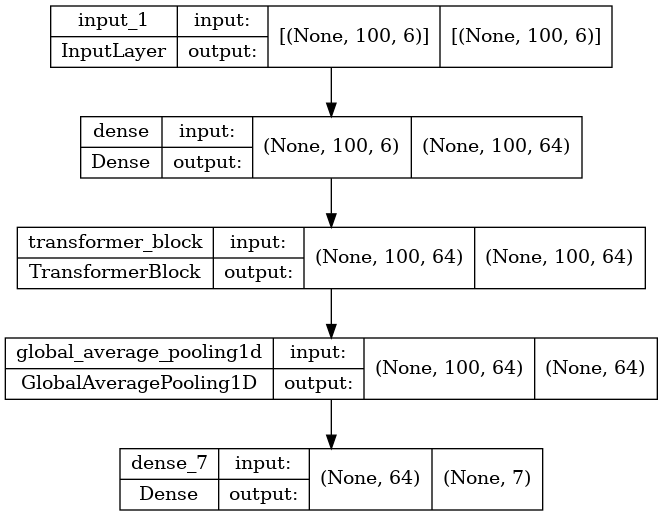

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='{}/model_{}.png'.format(outDir, ttl1), show_shapes=True)

from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, ttl1))

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# dataset 구분하는 마지막 column은 제거

if np.shape(trainX)[-1] == 7:
    trainX = trainX[:,:,:6]
    testX = testX[:,:,:6]

In [28]:
to_Train

True

In [29]:
#%%time
# fit network
if to_Train:
    verbose = 1
    history = model.fit(trainX, trainy, epochs=training_epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy)) #,  callbacks=callbacks)
    model.save(fnmodel)
    print('Saved model..... {}'.format(fnmodel))
else:
    model = load_model(fnmodel)
    print('Loaded model..... {}'.format(fnmodel))

Epoch 1/100
498/498 [==============================] - 5s 8ms/step - loss: 0.6287 - accuracy: 0.7717 - val_loss: 0.4081 - val_accuracy: 0.8582
Epoch 2/100
498/498 [==============================] - 4s 7ms/step - loss: 0.3573 - accuracy: 0.8828 - val_loss: 0.3174 - val_accuracy: 0.8923
Epoch 3/100
498/498 [==============================] - 4s 7ms/step - loss: 0.3071 - accuracy: 0.8992 - val_loss: 0.2815 - val_accuracy: 0.9076
Epoch 4/100
498/498 [==============================] - 4s 7ms/step - loss: 0.2786 - accuracy: 0.9081 - val_loss: 0.2718 - val_accuracy: 0.9078
Epoch 5/100
498/498 [==============================] - 4s 7ms/step - loss: 0.2514 - accuracy: 0.9186 - val_loss: 0.2476 - val_accuracy: 0.9216
Epoch 6/100
498/498 [==============================] - 4s 7ms/step - loss: 0.2405 - accuracy: 0.9226 - val_loss: 0.2539 - val_accuracy: 0.9145
Epoch 7/100
498/498 [==============================] - 4s 7ms/step - loss: 0.2248 - accuracy: 0.9270 - val_loss: 0.2481 - val_accuracy: 0.9191

Epoch 58/100
498/498 [==============================] - 4s 7ms/step - loss: 0.1152 - accuracy: 0.9609 - val_loss: 0.1769 - val_accuracy: 0.9514
Epoch 59/100
498/498 [==============================] - 4s 7ms/step - loss: 0.1122 - accuracy: 0.9622 - val_loss: 0.1704 - val_accuracy: 0.9514
Epoch 60/100
498/498 [==============================] - 4s 7ms/step - loss: 0.1080 - accuracy: 0.9631 - val_loss: 0.1866 - val_accuracy: 0.9455
Epoch 61/100
498/498 [==============================] - 4s 7ms/step - loss: 0.1084 - accuracy: 0.9635 - val_loss: 0.1769 - val_accuracy: 0.9512
Epoch 62/100
498/498 [==============================] - 4s 7ms/step - loss: 0.1049 - accuracy: 0.9649 - val_loss: 0.1834 - val_accuracy: 0.9481
Epoch 63/100
498/498 [==============================] - 4s 7ms/step - loss: 0.1139 - accuracy: 0.9623 - val_loss: 0.1686 - val_accuracy: 0.9549
Epoch 64/100
498/498 [==============================] - 4s 7ms/step - loss: 0.1036 - accuracy: 0.9641 - val_loss: 0.1769 - val_accuracy:

INFO:tensorflow:Assets written to: ./out/Transformer_cls7_epoch100_len100/model_Transformer_cls7_epoch100_len100/assets


INFO:tensorflow:Assets written to: ./out/Transformer_cls7_epoch100_len100/model_Transformer_cls7_epoch100_len100/assets


Saved model..... ./out/Transformer_cls7_epoch100_len100/model_Transformer_cls7_epoch100_len100


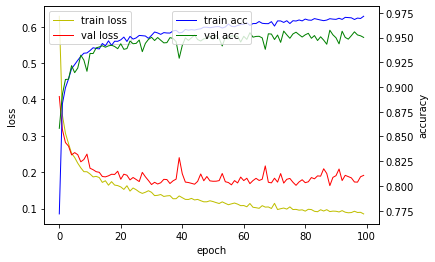

In [30]:
if to_Train:
    key_acc = 'accuracy'
    key_acc_val = 'val_accuracy'

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss', linewidth=1)
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss', linewidth=1)
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history[key_acc], 'b', label='train acc', linewidth=1)
    acc_ax.plot(history.history[key_acc_val], 'g', label='val acc', linewidth=1)
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper center')

## 결과

In [31]:
trainX.shape, trainy.shape

((31851, 100, 6), (31851, 7))

In [32]:
pred_train = model.predict(trainX, verbose=1)
pred_test = model.predict(testX, verbose=1)

250/250 [==============================] - 1s 3ms/step


In [33]:
trainy1 = np.argmax(trainy, axis=1)
pred_train1 = np.argmax(pred_train, axis=1)

In [34]:
testy1 = np.argmax(testy, axis=1)
pred_test1 = np.argmax(pred_test, axis=1)

In [35]:
from sklearn.metrics import classification_report
print(cellName[celltype],'Train result')
print(classification_report(trainy1, pred_train1, digits=4))   #classification_report( y_true , y_pred)

Transformer Train result
              precision    recall  f1-score   support

           0     0.9911    0.9878    0.9894      5830
           1     0.9216    0.9819    0.9508      6668
           2     0.9812    0.9281    0.9539      6588
           3     0.9706    0.9761    0.9733      3552
           4     0.9817    0.9738    0.9778      3250
           5     0.9928    0.9834    0.9881      3924
           6     0.9975    0.9892    0.9934      2039

    accuracy                         0.9710     31851
   macro avg     0.9766    0.9743    0.9752     31851
weighted avg     0.9719    0.9710    0.9711     31851



In [36]:
print(cellName[celltype],'Test result')
print(classification_report(testy1, pred_test1, digits=4))

Transformer Test result
              precision    recall  f1-score   support

           0     0.9704    0.9671    0.9688      1459
           1     0.9105    0.9623    0.9357      1670
           2     0.9691    0.9127    0.9400      1649
           3     0.9250    0.9427    0.9338       890
           4     0.9204    0.9362    0.9282       815
           5     0.9897    0.9745    0.9820       982
           6     0.9900    0.9706    0.9802       511

    accuracy                         0.9501      7976
   macro avg     0.9536    0.9523    0.9527      7976
weighted avg     0.9510    0.9501    0.9502      7976



In [37]:
# 모델 평가
print(model.metrics_names)
score0 = model.evaluate(trainX, trainy, verbose=1)
score = model.evaluate(testX, testy, verbose=1)

print('Train accuracy:', score0[1])
print('Test accuracy:', score[1])

['loss', 'accuracy']
250/250 [==============================] - 1s 3ms/step - loss: 0.1912 - accuracy: 0.9501
Train accuracy: 0.971021294593811
Test accuracy: 0.950100302696228


In [38]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score

# 'micro', 'macro', 'weighted'

f1 = f1_score(trainy1, pred_train1, average='macro')
f11 = f1_score(testy1, pred_test1, average='macro')

print('Train f1-score: ',f1)
print('Test f1-score: ',f11)

Train f1-score:  0.9752331446860969
Test f1-score:  0.9526774421784421


In [39]:
conf_matrix = pd.crosstab(trainy1, pred_train1) #행(row)이 정답, 열(col)이 맞춘거
print(conf_matrix)

col_0     0     1     2     3     4     5     6
row_0                                          
0      5759    21     1    20    26     1     2
1         6  6547    80    26     2     7     0
2         5   447  6114     8     3    11     0
3        30    30     2  3467    21     2     0
4         9    29     2    38  3165     4     3
5         2    19    30    10     4  3859     0
6         0    11     2     3     3     3  2017


In [40]:
conf_matrix = pd.crosstab(testy1, pred_test1) 
print(conf_matrix)

col_0     0     1     2    3    4    5    6
row_0                                      
0      1411     4     3   13   27    0    1
1         4  1607    35   17    4    2    1
2         6   125  1505    4    5    3    1
3        18     5     2  839   23    3    0
4        12    12     1   26  763    0    1
5         2     6     6    6    4  957    1
6         1     6     1    2    3    2  496


In [41]:
outdir = ''
ttl1fn = '{}_'.format(cell_name)
ttl1fn = ttl1fn.replace(' ', '')
print(ttl1fn)

Transformer_


In [42]:
def plot_confusion_matrix3x(actual, predicted, classes, title='Confusion Matrix', normalize=False, hide_classname = False, 
                            figsize=(4, 4), dpi=36, cmap=plt.cm.viridis, outdir=outDir):
    import itertools
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if not normalize:
        conf_matrix = pd.crosstab(actual, predicted) 
    else:
        conf_matrix = pd.crosstab(actual, predicted).apply(lambda r: r / r.sum(), axis=1)
        
    if np.shape(conf_matrix) != (len(classes), len(classes)):
        print(np.shape(conf_matrix))
        for i in range(len(classes)):
            if i not in conf_matrix.columns:
                conf_matrix[i] = 0.00
        conf_matrix = conf_matrix[[i for i in range(len(classes))]]

    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    ax = plt.gca()
    im = ax.imshow(conf_matrix, aspect=1.0, interpolation='nearest',cmap=cmap)
    
    plt.title(title, size=12)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05, aspect=20)
    plt.colorbar(im, cax=cax)
    
    
    if hide_classname:
        classes2 = []
        for k, _ in enumerate(classes):
            classes2.append('C{}'.format(k))
        classes = classes2
    
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=9) 
    ax.set_xticklabels(classes, fontsize=9, rotation=90)
    
   
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    thresh = 0.5
    
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        if conf_matrix[j][i] > thresh: #thresh[j]:
            color="white" 
        
        else :
            color = "black"  
        ax.text(j, i, format(conf_matrix[j][i], fmt), ha="center", va="center", color=color, fontsize=12)  #14  
        
#     ax.set_ylabel('Actual')
#     ax.set_xlabel('Predicted')
    ax.grid(False)
    plt.savefig('{}/final_{}.png'.format(outdir, title), bbox_inches='tight')
    
    return fig

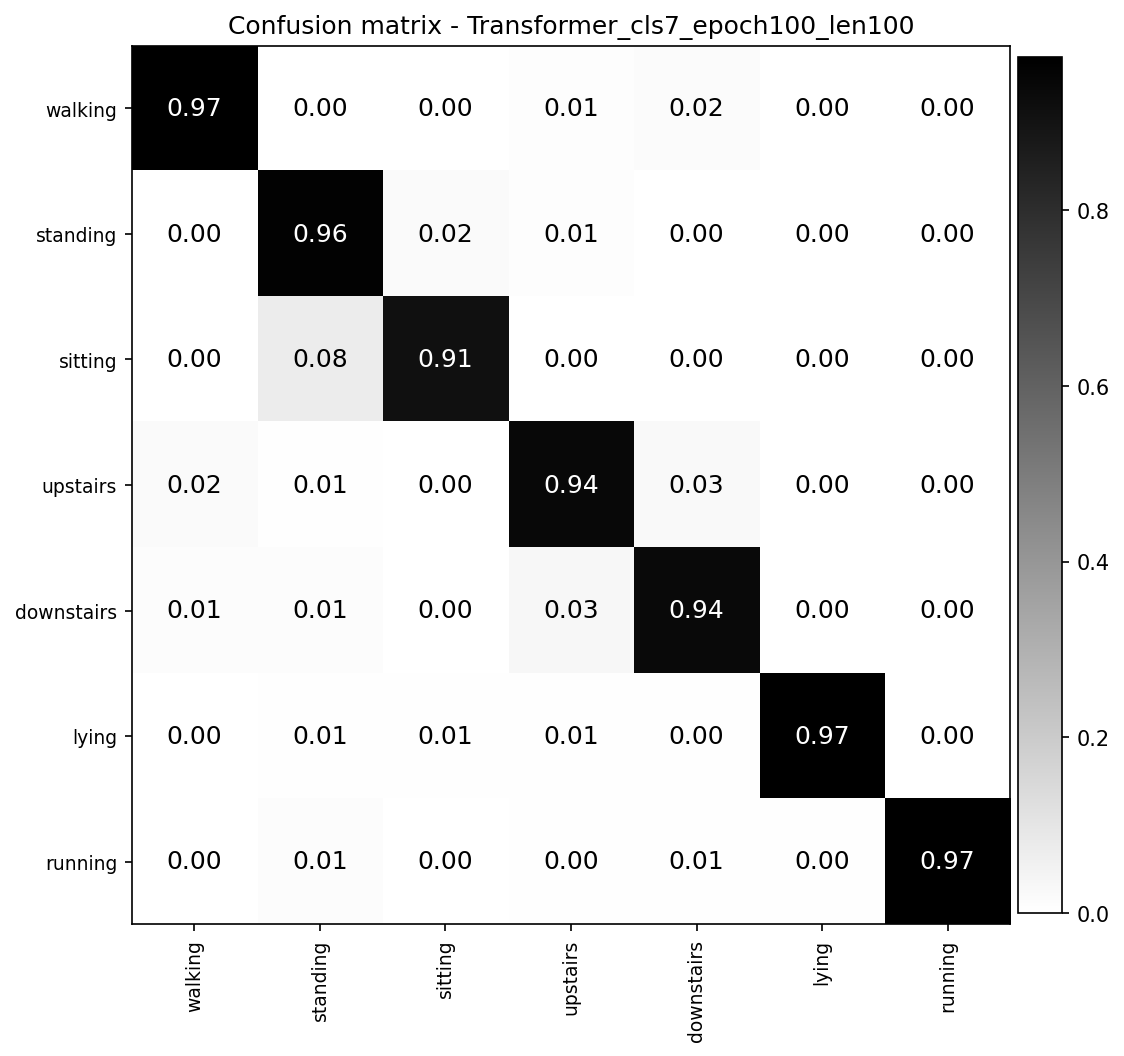

In [43]:
fig_conf = plot_confusion_matrix3x(testy1, pred_test1, class_name, title='Confusion matrix - {}'.format(ttl1), normalize=True,
                                   figsize=(8,8), dpi=150, hide_classname = False, outdir=outDir, cmap = 'binary')

## t-SNE

In [44]:
from sklearn.manifold import TSNE

In [45]:
emb_model = Model(model.input, model.layers[-2].output)
emb_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 dense (Dense)               (None, 100, 64)           448       
                                                                 
 transformer_block (Transfor  (None, 100, 64)          33472     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 33,920
Trainable params: 33,920
Non-trainable params: 0
_________________________________________________________________


In [46]:
embedding = emb_model.predict(testX)
print(embedding.shape)

(7976, 64)


In [47]:
%%time
proj = TSNE(n_components=2).fit_transform(embedding)

CPU times: user 2min 25s, sys: 21.1 s, total: 2min 47s
Wall time: 15.1 s


In [48]:
cmp = plt.get_cmap("tab20")  #tab10

100%|██████████| 7/7 [00:00<00:00, 308.71it/s]

./out/Transformer_cls7_epoch100_len100/embedding_Transformer_cls7_epoch100_len100.png


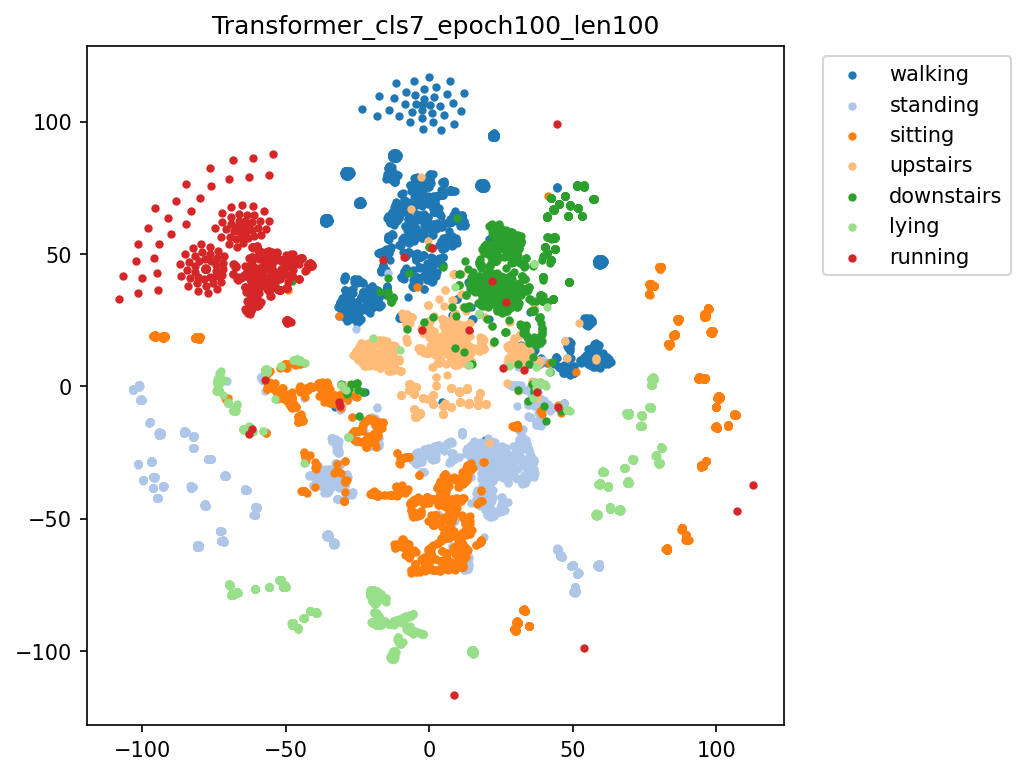

In [49]:
plt.figure(figsize=(6,6), dpi=150)

for i in tqdm(range(n_classes)):
    select_flag = testy1 == i
    plt_latent = proj[select_flag, :]
    plt.scatter(plt_latent[:, 0], plt_latent[:, 1], color=cmp(i), marker=".")
fnfig = "{}/embedding_{}.png".format(outDir, ttl1)#n_labeled_data
print(fnfig)
ttl2 = '{}'.format(ttl1)
plt.title(ttl2)
plt.gca().legend(class_name, bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig(fnfig, bbox_inches = "tight")